# Разведочный анализ данных и построение первых моделей

## Импорты

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

## Загрузка файла, общая информация

In [ ]:
start = pd.read_csv('../start_p2.csv')

df_final = pd.read_csv('../final_p2.1.csv')

# every (X, ir, pot2) formula properties is nan or formula is nan or activity is nan
condition = ~((df_final[["X", "IR", "pot2"]].isna().sum(axis=1) == 3) +\
              start[["formula", "activity"]].isna().any(axis=1))

df_final = df_final.drop(columns='id')
df_final = df_final[condition]
display(df_final.head(3))

print(f'Кол-во дубликатов: {df_final.duplicated().sum()}\n')
print(df_final.info())

## Предобработка данных

In [4]:
# Удаляем дубликаты
df_final = df_final.drop_duplicates()
print(f'Кол-во дубликатов: {df_final.duplicated().sum()}\n')

Кол-во дубликатов: 0



In [5]:
# Определяем некорректные значения для преобразования в float
invalid_values = list(df_final['Km'][~df_final['Km'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()])
print(len(invalid_values))
print(set(invalid_values))

991
{nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

In [6]:
# Определяем некорректные значения для преобразования в float
invalid_values = list(df_final['Vmax'][~df_final['Vmax'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()])
print(len(invalid_values))
print(set(invalid_values))

1577
{nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [7]:
# Определяем некорректные значения для преобразования в float
invalid_values = list(df_final['ph'][~df_final['ph'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()])
print(len(invalid_values))
print(set(invalid_values))

553
{nan, '6.40-6.60', '3-7.4', '~7.4', '~6.5-7.0', '3.54 - 6.4', '0.1 mol/L NaAC-AC buffer', '7.0-11.0', '5.00 ± 0.02', '10-11', '5.2 ± 0.2', '4.0-10.0', '4.0 - 5.0', '5 mM', '4.0 - 5.6', '7.2-7.4', '6.0 and 7.4', '~7.0', '~7', '2-11', '3 - 7', '3-6', '6-10', '8.0-10.5', '~5.0', '2-6', '4.0-8.0', '2.2 - 8.0', '1-7', '4.0 - 6.0', '5 ± 0.5', '8 ± 0.2', '5.0 - 7.0', '2-8', '5.2 - 9.3', '7.0 - 7.4', '3-10', '2.0 - 9.0'}


In [8]:
# Преобразование типов и замена "no" на NaN
df_final['Vmax'] = pd.to_numeric(df_final['Vmax'].replace("no", np.nan), errors='coerce')
df_final['Km'] = pd.to_numeric(df_final['Km'].replace("no", np.nan), errors='coerce')
df_final['ph'] = pd.to_numeric(df_final['ph'].where(lambda ph: ~ph.isin(invalid_values)), errors='coerce')
# Проверка результата
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2959 entries, 7 to 9036
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Km                  1968 non-null   float64
 1   Vmax                1382 non-null   float64
 2   activity            2959 non-null   float64
 3   X                   2946 non-null   float64
 4   IR                  1023 non-null   float64
 5   pot2                2095 non-null   float64
 6   ph                  2406 non-null   float64
 7   temp                2665 non-null   float64
 8   dstr                1606 non-null   float64
 9   lgCmin              1810 non-null   float64
 10  lgCmax              1794 non-null   float64
 11  Cmin                1810 non-null   float64
 12  Cmax                1794 non-null   float64
 13  lgCconst            2125 non-null   float64
 14  Cconst              2125 non-null   float64
 15  lgCcat              1043 non-null   float64
 16  Ccat       

## Исследовательский анализ

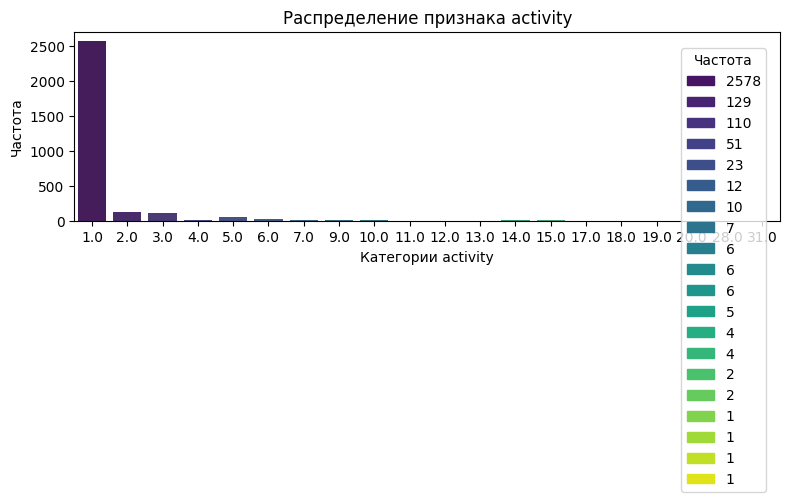

In [12]:
# Подсчёт количества элементов для каждой категории
activity_counts = df_final['activity'].value_counts()

# Создание палитры с разными цветами для категорий
palette = sns.color_palette('viridis', len(activity_counts))

# Построение countplot с разными цветами для каждой категории
plt.figure(figsize=(8, 4))
sns.countplot(x='activity', data=df_final, hue='activity', palette=palette, dodge=False, legend=False)

# Добавление легенды с количеством элементов
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in range(len(activity_counts))]
labels = [f"{count}" for count in activity_counts.values]
plt.legend(handles, labels, title="Частота", bbox_to_anchor=(0.85, 0.95), loc='upper left')

# Настройка графика
plt.title('Распределение признака activity')
plt.xlabel('Категории activity')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

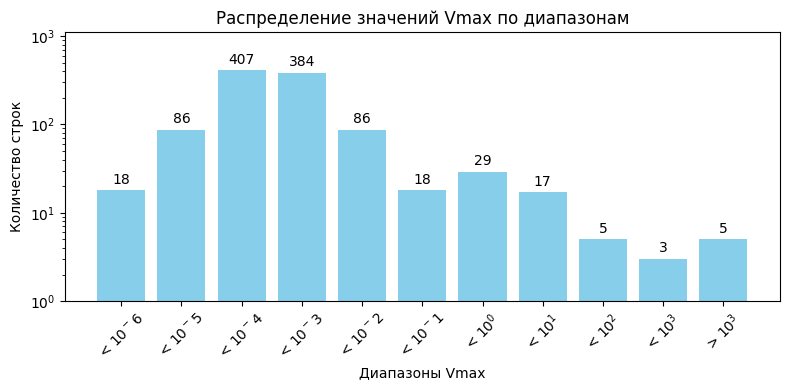

In [8]:
# Определяем диапазоны
bins = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, float('inf')]
labels = ['< $10^-6$', '< $10^-5$', '< $10^-4$', '< $10^-3$', '< $10^-2$', '< $10^-1$', '< $10^0$', '< $10^1$', '< $10^2$', '< $10^3$' , '> $10^3$']

# Подсчёт количества строк в каждом диапазоне
df_final['range'] = pd.cut(df_final['Vmax'], bins=bins, labels=labels, include_lowest=True)
counts = df_final['range'].value_counts(sort=False)

# Построение диаграммы
plt.figure(figsize=(8, 4))
bars = plt.bar(labels, counts, color='skyblue')
plt.title('Распределение значений Vmax по диапазонам')
plt.xlabel('Диапазоны Vmax')
plt.ylabel('Количество строк')

# Добавление подписей на графике с одинаковым расстоянием
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.1, str(count), 
             ha='center', va='bottom', fontsize=10)

# Настройка логарифмической шкалы на оси Y и фиксирование максимума
plt.yscale('log')
plt.ylim(1, 1100)

# Указываем степени 10 на оси Y
plt.gca().yaxis.set_major_locator(plt.LogLocator(base=10.0))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$" if x > 0 else ""))

# Убираем угол поворота подписей на оси X
plt.xticks(rotation=45)

# Настройка отображения
plt.tight_layout()
plt.show()

# Удаляем вспомогательную колонку
df_final = df_final.drop(columns='range')

## Корреляционный анализ

In [13]:
# Укажите явные интервальные столбцы
interval_cols = df_final.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Вычисление корреляционной матрицы Phik
phik_corr = df_final.phik_matrix(interval_cols=interval_cols)

/home/oleg/Programs/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/oleg/Programs/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:172: RuntimeWarning: invalid value encountered in add
  y += start
/home/oleg/Programs/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/oleg/Programs/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:172: RuntimeWarning: invalid value encountered in add
  y += start
/home/oleg/Programs/.venv/lib/python3.12/site-packages/phik/phik.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_binned.replace(defs.UF, np.nan, 

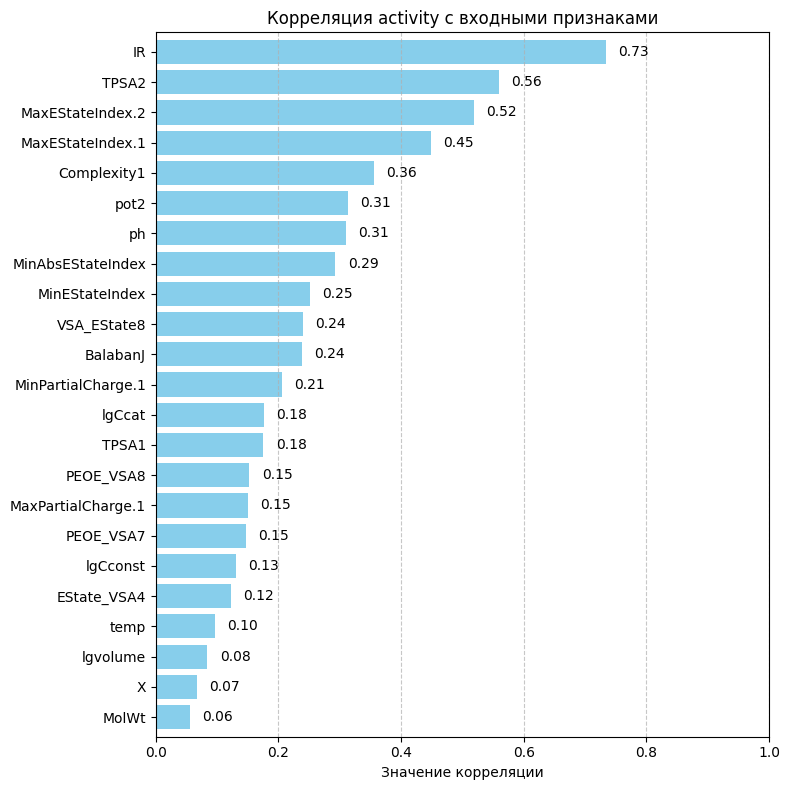

In [18]:
# Фильтрация значений из столбца 'activity' в диапазоне (0, 1)
vmax_corr = phik_corr['activity'][(phik_corr['activity'] > 0) & (phik_corr['activity'] < 1)].sort_values()

# Построение горизонтальной диаграммы
plt.figure(figsize=(8, 8))
bars = vmax_corr.plot(kind='barh', color='skyblue', width=0.8)
plt.title('Корреляция activity с входными признаками')
plt.xlabel('Значение корреляции')
plt.ylabel('')

# Настройка оси X и сетки
plt.xlim(0, 1)  # Фиксируем диапазон оси X от 0 до 1
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Добавляем вертикальную сетку

# Добавление подписей на график
for index, value in enumerate(vmax_corr):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center')

# Отображение
plt.tight_layout()
plt.show()

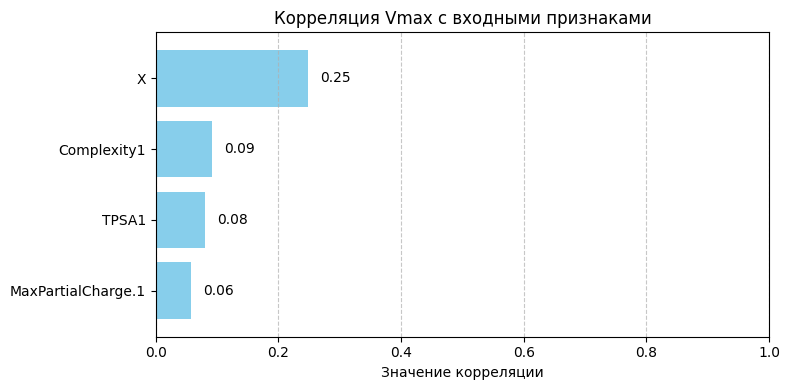

In [15]:
# Фильтрация значений из столбца 'Vmax' в диапазоне (0, 1)
vmax_corr = phik_corr['Vmax'][(phik_corr['Vmax'] > 0) & (phik_corr['Vmax'] < 1)].sort_values()

# Построение горизонтальной диаграммы
plt.figure(figsize=(8, 4))
bars = vmax_corr.plot(kind='barh', color='skyblue', width=0.8)
plt.title('Корреляция Vmax с входными признаками')
plt.xlabel('Значение корреляции')
plt.ylabel('')

# Настройка оси X и сетки
plt.xlim(0, 1)  # Фиксируем диапазон оси X от 0 до 1
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Добавляем вертикальную сетку

# Добавление подписей на график
for index, value in enumerate(vmax_corr):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center')

# Отображение
plt.tight_layout()
plt.show()

In [23]:
vmax_corr#.index

MolWt                 0.055141
X                     0.066782
lgvolume              0.084100
temp                  0.096252
EState_VSA4           0.122192
lgCconst              0.130999
PEOE_VSA7             0.146640
MaxPartialCharge.1    0.149788
PEOE_VSA8             0.152720
TPSA1                 0.175383
lgCcat                0.175862
MinPartialCharge.1    0.205447
BalabanJ              0.238682
VSA_EState8           0.239491
MinEStateIndex        0.251848
MinAbsEStateIndex     0.292972
ph                    0.309543
pot2                  0.313703
Complexity1           0.355521
MaxEStateIndex.1      0.449260
MaxEStateIndex.2      0.518235
TPSA2                 0.559244
IR                    0.733896
Name: activity, dtype: float64

In [21]:
# Сохраняем входные признаки, которые коррелируют с целевыми
corr_with_vmax = [
    "lgCcat", "BalabanJ", "Cconst", "BCUT2D_CHGLO", "lgCconst", "lgvolume", "lgCmin", "Sufrace", "activity"
]
corr_with_activity = [
    'MolWt', 'X', 'lgvolume', 'temp', 'EState_VSA4', 'lgCconst',
    'PEOE_VSA7', 'MaxPartialCharge.1', 'PEOE_VSA8', 'TPSA1', 'lgCcat',
    'MinPartialCharge.1', 'BalabanJ', 'VSA_EState8', 'MinEStateIndex',
    'MinAbsEStateIndex', 'ph', 'pot2', 'Complexity1', 'MaxEStateIndex.1',
    'MaxEStateIndex.2', 'TPSA2', 'IR'
]

### Сохраняем списки коррелирующими признаками в файлы

In [22]:
# Сохранение списков в файлы
with open("corr_with_vmax.txt", "w") as file_vmax:
    file_vmax.write("\n".join(corr_with_vmax))
with open("corr_with_activity.txt", "w") as file_activity:
    file_activity.write("\n".join(corr_with_activity))
    
# Проверка, что файлы сохранены
if os.path.exists("corr_with_vmax.txt"):
    print("Файл 'corr_with_vmax.txt' успешно сохранен.")
else:
    print("Ошибка: файл 'corr_with_vmax.txt' не сохранен.")

if os.path.exists("corr_with_activity.txt"):
    print("Файл 'corr_with_activity.txt' успешно сохранен.")
else:
    print("Ошибка: файл 'corr_with_activity.txt' не сохранен.")

Файл 'corr_with_vmax.txt' успешно сохранен.
Файл 'corr_with_activity.txt' успешно сохранен.
